In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Минипроект

Опираясь на [карту](https://eusipa.org/wp-content/uploads/European_map_20160530_2016.pdf) Европейской ассоциации структурных инвестиционных
продуктов (EUSIPA) и ее [российскую адаптацию](https://naufor.ru/tree.asp?n=22890)

привести 2-3 ссылки на

*   структурные продукты, представленные на россиском рынке,
*   доступные наборы данных (напрмер, [HKEX](https://www.hkex.com.hk/Products/Securities/Structured-Products/Trading-Information-and-Historical-Data?sc_lang=en)).

Структурные продукты

https://www.moex.com/ru/issue.aspx?board=EQWD&code=XS1654213294

http://www.sberbank.ru/ru/person/investments/structured_products?tab=showcase

Данные

https://www.finam.ru/

https://www.investing.com/equities/structured-products-corts-tr-peco

# Cтруктурный продукт с полной защитой капитала

## СП с использованием бинарных опционов

Пример. Имеется 0,1 млн рублей, которые клиент готов инвестировать на 1 год. Ожидается, что текущая цена акции, равная 100 руб., не изменится более чем на 10%. Волатильность акции – 30%, депозитная процентная ставка и безрисковая процентная
ставка – 7%.

Постройте структурный продукт с полной защитой капитала и использованием опционной стратегии бинарный диапазон (binary range).

In [2]:
# оценка стоимости бинарного опциона колл
def binary_option_call(t, S, K, T, r, q, sigma):

    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(d1)

# оценка стоимости бинарного опциона пут
def binary_option_put(t, S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r+sigma**2/2)*(T))/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if t == 'cash-or-nothing':
      return np.exp(-r*T)*norm.cdf(-d2)
    if t == 'asset-or-nothing':
      return S*np.exp(-q*T)*norm.cdf(-d1)

In [3]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3
n = 100

In [4]:
K=90
b90 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
K=110
b110 = binary_option_call('cash-or-nothing', S, K, T, r, q, sigma)
print('digital range = ', b90-b110)

digital range =  0.24307515482345715


In [5]:
risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(b90-b110))
print('количество опционных стратегий', Q)

количество опционных стратегий 27813


In [6]:
print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

максимальная доходность, годовых =  0.27813
максимальная доходность, непрерывно =  0.24539807222181784


In [7]:
def call(S, K, T, sigma, r, q):
    d1 = (np.log (S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp (-r * T) * norm.cdf(d2)

Пример. Постройте график доходности структурного продукта в сравнении с доходностью базового актива и безрисковой ставки.

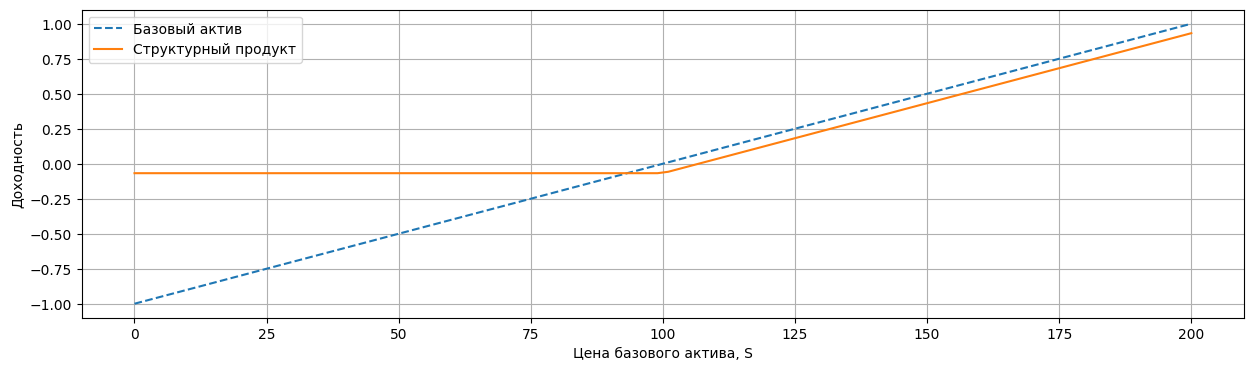

In [8]:
risk_part = N - N * np.exp(-r * T)
c = call(S, K, T, sigma, r, q)
PR = S * round(risk_part / c) / N

underlying_asset_profit = np.linspace(- S, S, n) / S
struct_product_profit = np.maximum(0, underlying_asset_profit) - round(risk_part / c) * c / N

x = np.linspace(0, 2 * S, n)
plt.figure(figsize=(15, 4))
#plt.title('Profit UA vs OC')
plt.plot(x, underlying_asset_profit, '--', label='Базовый актив')
plt.plot(x, struct_product_profit,  label='Структурный продукт')
plt.ylabel('Доходность')
plt.xlabel('Цена базового актива, S')
plt.grid()
plt.legend()
plt.show()

Пример. Постройте график зависимости коэффициента участия от встроенной комиссии, проварьируйте комиссию от 0 до 10% с шагом 1%.

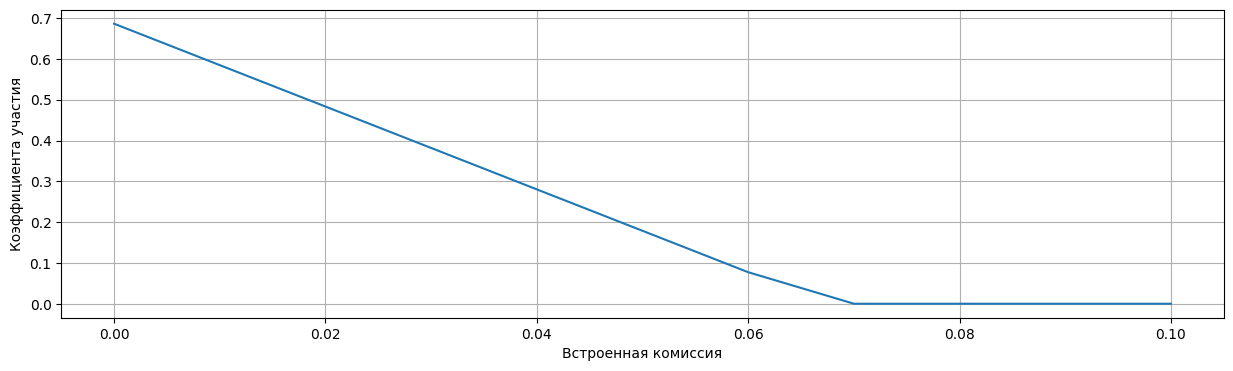

In [9]:
da = np.exp(-r * T) * N

Q = lambda fees: ( N * (1 - fees)  - da ) / c
fees = (np.linspace(0.0, 0.1, 11))
PR = K * Q(fees) / N

plt.figure(figsize=(15, 4))
#plt.title('PR from fees value')
plt.plot(fees, np.maximum(PR, 0))
plt.xlabel('Встроенная комиссия')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Постройте график зависимости коэффициента участия от процентных ставок (депозитная и безрисковая ставки равны), проварьируйте ставки от 0 до 20% с шагом 1%.

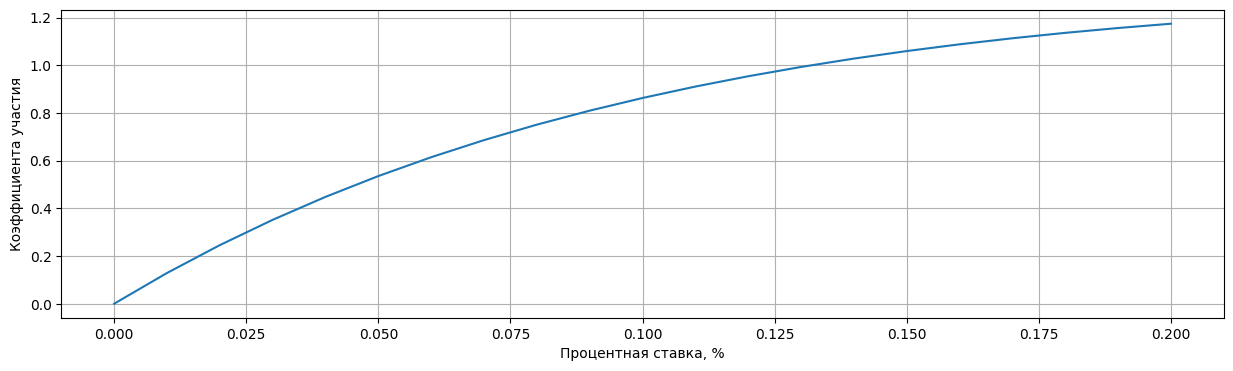

In [10]:
Q = lambda da, c: ( N * (1 - 0.0)  - da ) / c
rs = np.linspace(0, 0.2, 21)
cs = np.fromiter((call(S, K, T, sigma, ri, q) for ri in rs), dtype=np.float32)
das = np.exp(-rs * T) * N
Qs = np.fromiter((Q(da,c) for da,c in zip(das, cs)), dtype=np.float32)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from interest rate')
plt.plot(rs, np.maximum(PR, 0))
plt.xlabel('Процентная ставка, %')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

### Задача

Задача. Постройте трехмерных график зависимости коэффициента участия от депозитной и безрисковой ставок, проварьируйте ставки от 0 до 25% с шагом 1%.

In [11]:
def calculate_Q(da, c, N):
    """Calculate the participation coefficient Q."""
    return (N * (1 - 0.0) - da) / c

def calculate_participation_rate(deposit_rates, risk_free_rates, call_function, S, K, T, sigma, N, q):
    """Calculate the participation rate matrix for various deposit and risk-free rates."""
    Q_matrix = np.zeros((len(deposit_rates), len(risk_free_rates)))
    
    # Loop over the deposit and risk-free rates to fill the matrix
    for i, deposit_rate in enumerate(deposit_rates):
        for j, risk_free_rate in enumerate(risk_free_rates):
            cs = call_function(S, K, T, sigma, risk_free_rate, q)  # Call option price
            da = np.exp(-risk_free_rate * T) * N  # Discounted amount of the asset
            Qs = calculate_Q(da, cs, N)  # Participation coefficient
            PR = K * Qs / N  # Participation rate formula
            Q_matrix[i, j] = np.maximum(PR, 0)  # Ensure the value is non-negative
            
    return Q_matrix

def plot_participation_rate_surface(deposit_rates, risk_free_rates, Q_matrix):
    """Plot the 3D surface of the participation rate matrix."""
    X, Y = np.meshgrid(deposit_rates, risk_free_rates)
    Z = Q_matrix
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    
    # Label the axes
    ax.set_xlabel('Deposit Rate, %')
    ax.set_ylabel('Risk-free Rate, %')
    ax.set_zlabel('Participation Coefficient')
    ax.set_title('Participation Coefficient Dependency on Deposit and Risk-free Rates')
    
    plt.show()

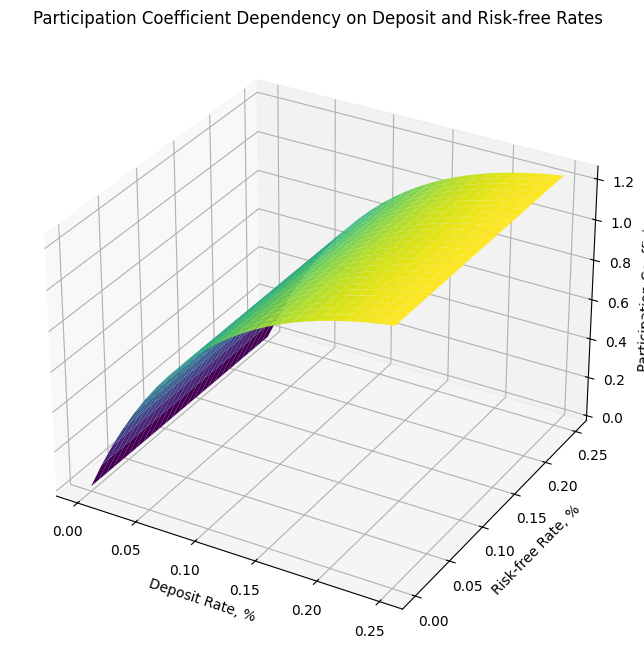

In [12]:
deposit_rates = np.linspace(0, 0.25, 26)
risk_free_rates = np.linspace(0, 0.25, 26)

# Calculate participation rate matrix
Q_matrix = calculate_participation_rate(deposit_rates, risk_free_rates, call, S, K, T, sigma, N, q)

# Plot the results
plot_participation_rate_surface(deposit_rates, risk_free_rates, Q_matrix)

Пример. Постройте график зависимости коэффициента участия от волатильности базового актива, проварьируйте волатильность от 0 до
100% с шагом 5%.

C:\Users\Mirom\AppData\Local\Temp\ipykernel_16532\102214163.py:4: RuntimeWarning: divide by zero encountered in divide
  Q = lambda c: ( N * (1 - 0.0)  - da ) / c


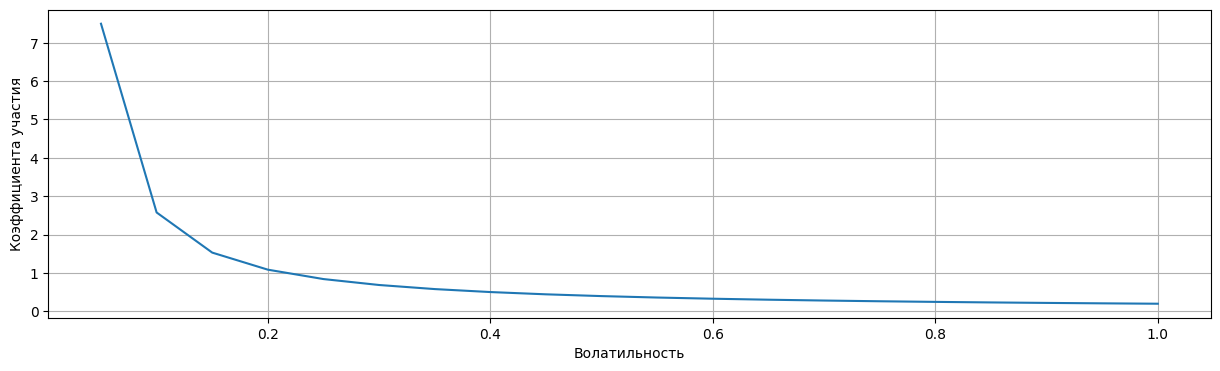

In [13]:
vs = np.linspace(1e-5, 1, 21)
cs = call(S, K, T, vs, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from volatility')
plt.plot(vs, PR)
plt.xlabel('Волатильность')
plt.ylabel('Коэффициента участия')
plt.grid()
plt.show()

Пример. Постройте график влияния срока продукта (от 0 до 100 лет, с
шагом 6 месяцев) на соотношение безрискового и рискового вложений.

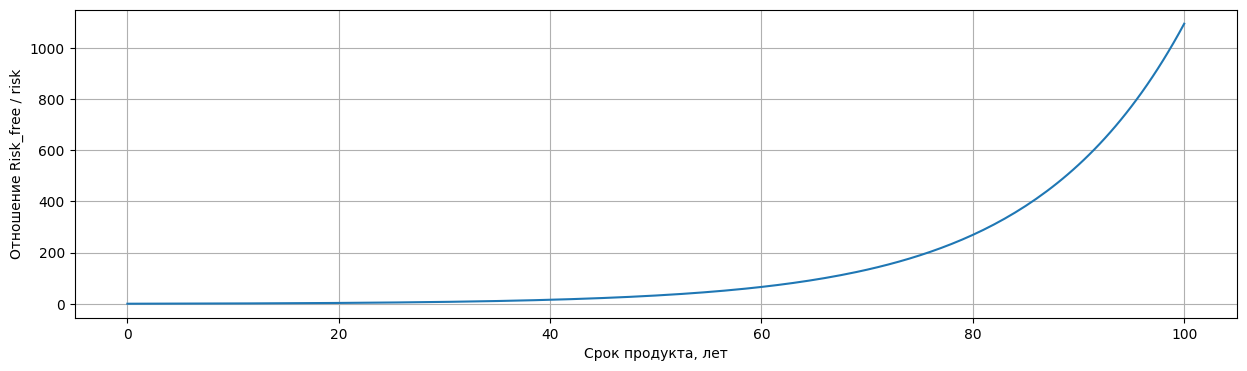

In [14]:
Ts = np.linspace(1e-5, 100, 201)
risk_parts = N - N * np.exp(-r * Ts)
ratios = risk_parts / (N - risk_parts)

plt.figure(figsize=(15, 4))
#plt.title('Risk-free to risk fraction relation on maturity date')
plt.plot(Ts, ratios)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Отношение Risk_free / risk')
plt.grid()
plt.show()

Пример. Постройте график зависимости коэффициента участия от срока
продукта (от 0 до 20 лет, с шагом 6 месяцев).


C:\Users\Mirom\AppData\Local\Temp\ipykernel_16532\4026867300.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c


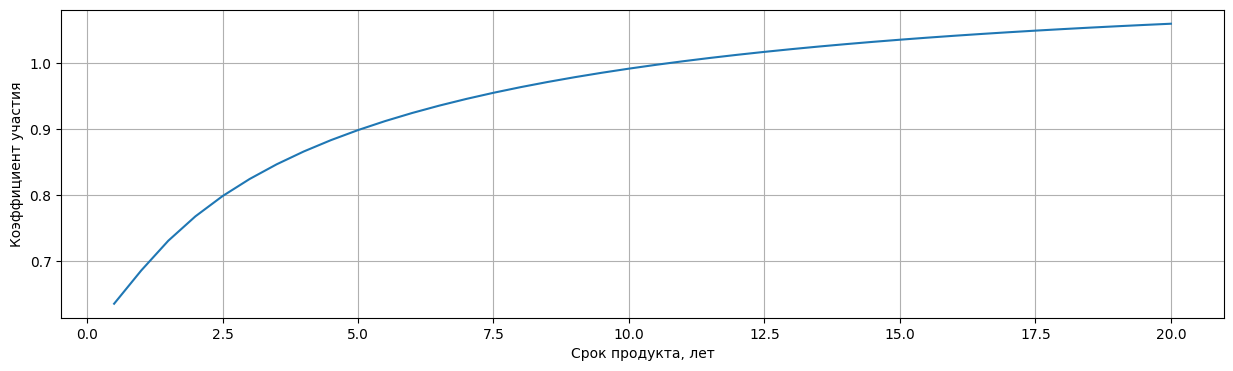

In [15]:
Ts = np.linspace(1e-5, 20, 41)
cs = call(S, K, Ts, sigma, r, q)
das = np.exp(-r * Ts) * N
Q = lambda c, d: ( N * (1 - 0.0)  - d ) / c
Qs = np.fromiter((Q(c, d) for c,d in zip(cs, das)), dtype=np.float64)
PR = K * Qs / N

plt.figure(figsize=(15, 4))
#plt.title('PR from maturity date')
plt.plot(Ts, PR)
plt.xlabel('Срок продукта, лет')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график коэффициента участия от страйка продукта
(от 80 до 140, с шагом 10).

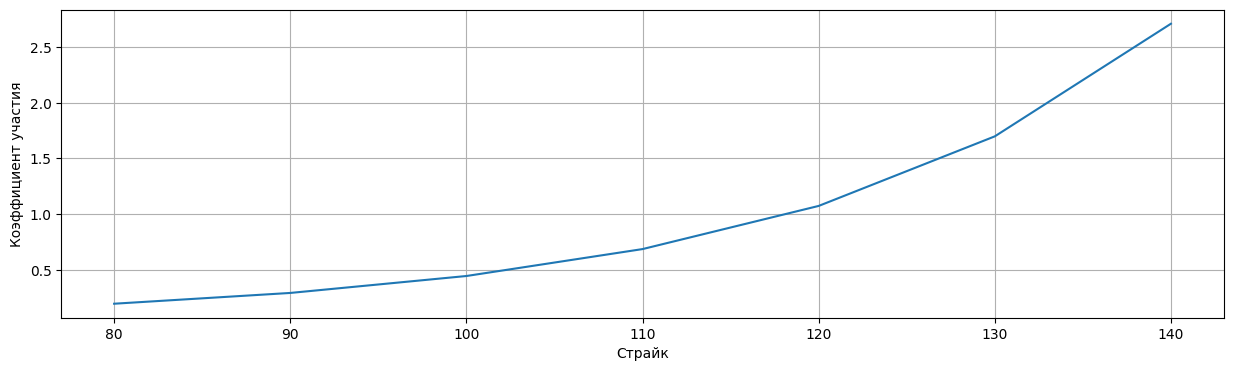

In [16]:
Ks = np.linspace(80, 140, 7)
cs = call(S, Ks, T,  sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
Qs = Q(cs)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
plt.plot(Ks, PR)
plt.xlabel('Страйк')
plt.ylabel('Коэффициент участия')
plt.grid()
plt.show()

Пример. Постройте график доходности продуктов с разными страйками и
100% защитой капитала.

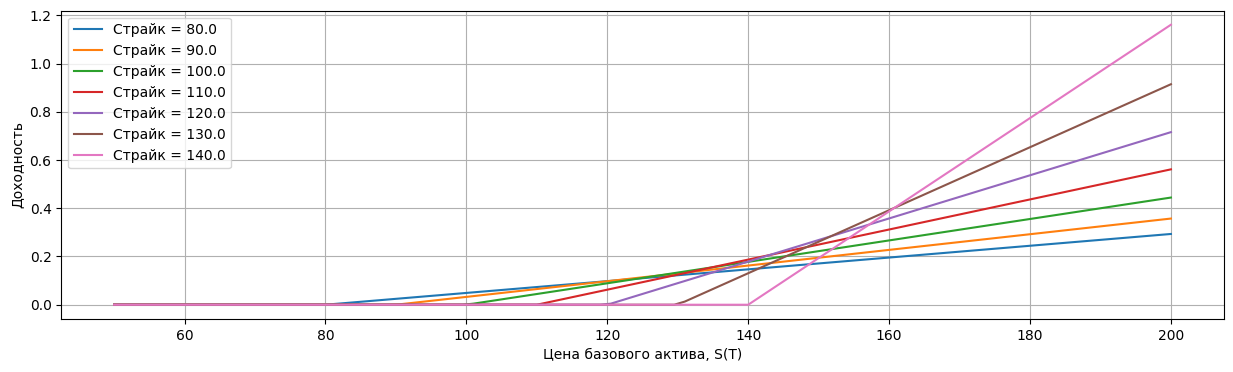

In [17]:
Ks = np.linspace(80, 140, 7)

cs = call(S, Ks, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da) / c
Qs = Q(cs)
# Qs = np.fromiter((Q(c) for c in zip(cs, das)), dtype=np.float64)
PR = np.fromiter(((Kv * Qv / N) for Kv, Qv in zip(Ks, Qs)), dtype=np.float32)
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('Profit on UA')
for i, pr in enumerate(PR):
    rs = np.maximum(0, pr * (Sm - Ks[i]) / Ks[i])
    plt.plot(Sm, rs, label=f'Страйк = {Ks[i]}')
plt.xlabel('Цена базового актива, S(T)')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

Пример. Постройте графики доходностей продуктов с одним страйком и
разной степенью защиты капитала (от 80% до 150%, с шагом 10%)

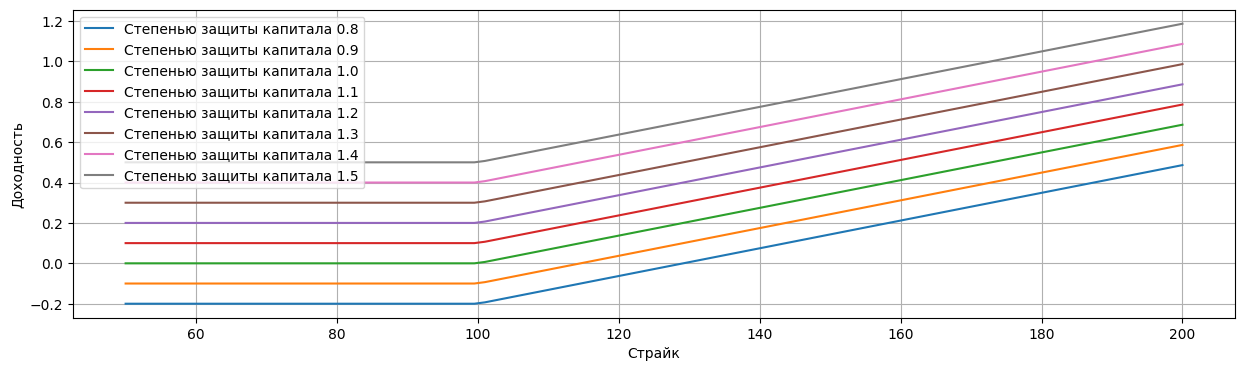

In [18]:
gs = np.linspace(0.8, 1.5, 8)
c = call(S, K, T, sigma, r, q)
da = np.exp(-r * T) * N
Q = lambda c: ( N * (1 - 0.0)  - da ) / c
PR = K * Q(c) / N
Sm = np.linspace(0.5*S, 2*S, 101)

plt.figure(figsize=(15, 4))
#plt.title('PR from strike')
for i, g in enumerate(gs):
    returns = np.maximum(g - 1, (g - 1) + PR * (Sm - S)/S)
    plt.plot(Sm, returns, label=f'Степенью защиты капитала {g}')
plt.xlabel('Страйк')
plt.ylabel('Доходность')
plt.legend()
plt.grid()
plt.show()

### Задача

Задача. В условиях примера постройте 3D график зависимости доходности структурного продукта от

*   страйков и
*   степени защиты капитала.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def call_option_price(S, K, T, sigma, r, q):
    """Calculate the European call option price using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C

def calculate_participation_rate(K, c, N, r, T, sigma, S, q):
    """Calculate the participation rate based on the given parameters."""
    da = np.exp(-r * T) * N
    Q = (N * (1 - 0.0) - da) / c
    PR = K * Q / N
    return PR

def calculate_returns(S, g, PR, K, N):
    """Calculate the returns for the structured product."""
    Sm = np.linspace(0.5 * S, 2 * S, 101)  # Asset price range for simulation
    returns = np.maximum(g - 1, (g - 1) + PR * (Sm - S) / S)  # Structured product return
    return np.mean(returns)

def generate_returns_grid(K_values, g_values, S, T, sigma, r, q, N):
    """Generate a grid of returns based on the strike price and capital protection factor."""
    K_grid, g_grid = np.meshgrid(K_values, g_values)
    returns_grid = np.zeros_like(K_grid)
    
    # Calculate returns for each combination of K and g
    for i, K in enumerate(K_values):
        for j, g in enumerate(g_values):
            # Calculate call option price
            c = call_option_price(S, K, T, sigma, r, q)
            
            # Calculate participation rate
            PR = calculate_participation_rate(K, c, N, r, T, sigma, S, q)
            
            # Calculate returns for the given parameters
            returns_grid[j, i] = calculate_returns(S, g, PR, K, N)
    
    return K_grid, g_grid, returns_grid

def plot_returns_surface(K_grid, g_grid, returns_grid):
    """Plot the 3D surface of returns."""
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(K_grid, g_grid, returns_grid, cmap='viridis')
    
    # Label the axes
    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Capital Protection Degree (g)')
    ax.set_zlabel('Return (%)')
    ax.set_title('Dependence of Structured Product Returns on Strike Price and Capital Protection Degree')
    
    plt.show()

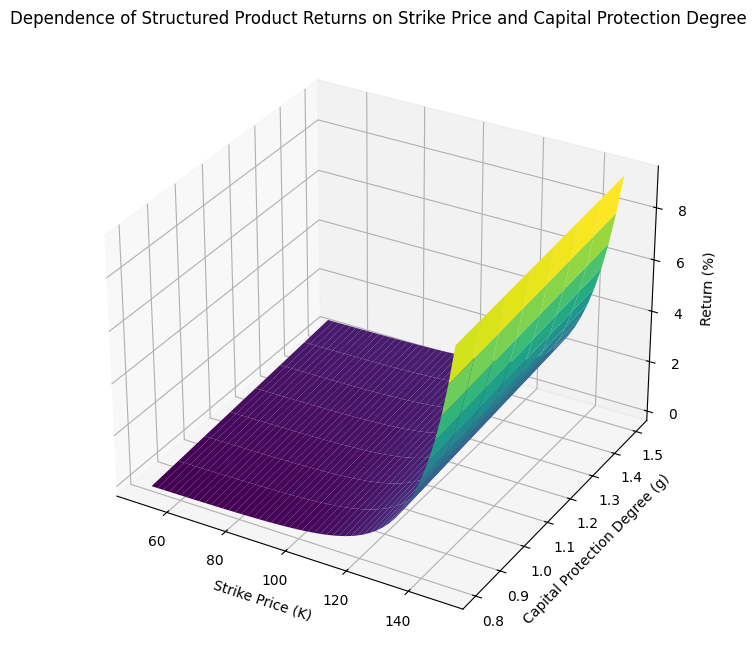

In [27]:
# Example parameters (replace with your actual values)
S = 100  # Spot price (example)
T = 1    # Time to maturity (example)
sigma = 0.2  # Volatility (example)
r = 0.05  # Risk-free rate (example)
q = 0.02  # Dividend yield (example)
N = 1_000_000  # Number of shares (example)

# Define strike prices and capital protection factors
K_values = np.linspace(50, 150, 50)
g_values = np.linspace(0.8, 1.5, 8)

# Generate returns grid
K_grid, g_grid, returns_grid = generate_returns_grid(K_values, g_values, S, T, sigma, r, q, N)

# Plot the results
plot_returns_surface(K_grid, g_grid, returns_grid)

Пример. В условиях примера для опциона колл повторите все расчеты с использованием бинарной стратегии, основанной на покупке и продаже европейского опциона пут.

Ширину диапазона доходности базового актива задать самостоятельно. Выбор обосновать.

In [20]:
S = 100
K = 100
T = 1
r = 0.07
q = 0
N = 100000
sigma = 0.3

K1 = 100
bo1 = binary_option_put('cash-or-nothing', S, K1, T, r, q, sigma)
K2=110
bo2 = binary_option_put('cash-or-nothing', S, K2, T, r, q, sigma)
print('digital range = ', -bo1+bo2)

risk_part = N - N*np.exp(-r*T)
Q = round(risk_part/(-bo1+bo2))
print('количество опционных стратегий', Q)

print('максимальная доходность, годовых = ', (N+Q)/(N*T)-1)
print('максимальная доходность, непрерывно = ', np.log((N+Q)/(N*T)))

digital range =  0.11734811871736428
количество опционных стратегий 57612
максимальная доходность, годовых =  0.57612
максимальная доходность, непрерывно =  0.45496613066900204


Пример. Постройте график функции выплат для бинарных стратегий, основанных
*   на покупке и продаже опционов колл,
*  на покупке и продаже опционов пут.



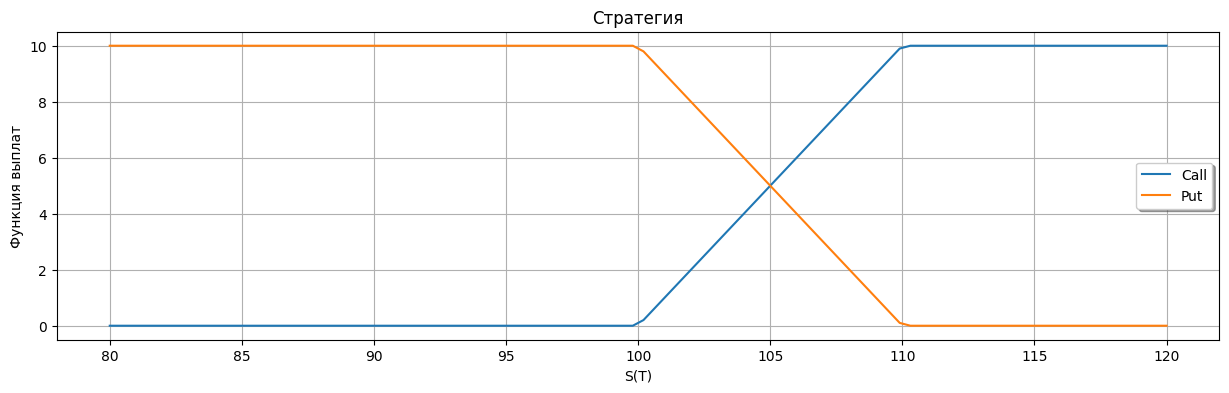

In [21]:
S = np.linspace(80, 120, 100)

C1 = np.maximum(S - K1, 0)
C2 = np.maximum(S - K2, 0)

P1 = np.maximum(-S + K1, 0)
P2 = np.maximum(-S + K2, 0)
plt.figure(figsize=(15,4))
plt.plot(S, C1 - C2, label=f'Call')
plt.plot(S, -P1 + P2, label=f'Put')
plt.legend(loc = 'best', fancybox = True, shadow = True)

plt.xlabel(f"S(T)")
plt.ylabel("Функция выплат")
plt.title("Стратегия")

plt.grid(True)
plt.show()

### Задача

Задача. Постройте графики трехмерных поверхностей для описания зависимости коэффициента участия при использовании бинарных опционов  
*   кол,
*   пут

от стоимости базового актива и количества дней до экспирации.

In [31]:
def participation_coefficient(option_type, option, S, K, T, sigma):
    d1 = (np.log(S/K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
        if option_type == 'cash-or-nothing':
            return norm.cdf(d2)
        elif option_type == 'asset-or-nothing':
            return norm.cdf(d1)
    elif option == 'put':
        if option_type == 'cash-or-nothing':
            return norm.cdf(-d2)
        elif option_type == 'asset-or-nothing':
            return norm.cdf(-d1)

def plot_3d(X, Y, Z, title, zlabel, cmap='viridis'):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, edgecolor='none')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Цена базового актива (S)', fontsize=12)
    ax.set_ylabel('Дни до экспирации', fontsize=12)
    ax.set_zlabel(zlabel, fontsize=12)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20)
    plt.tight_layout()
    plt.show()

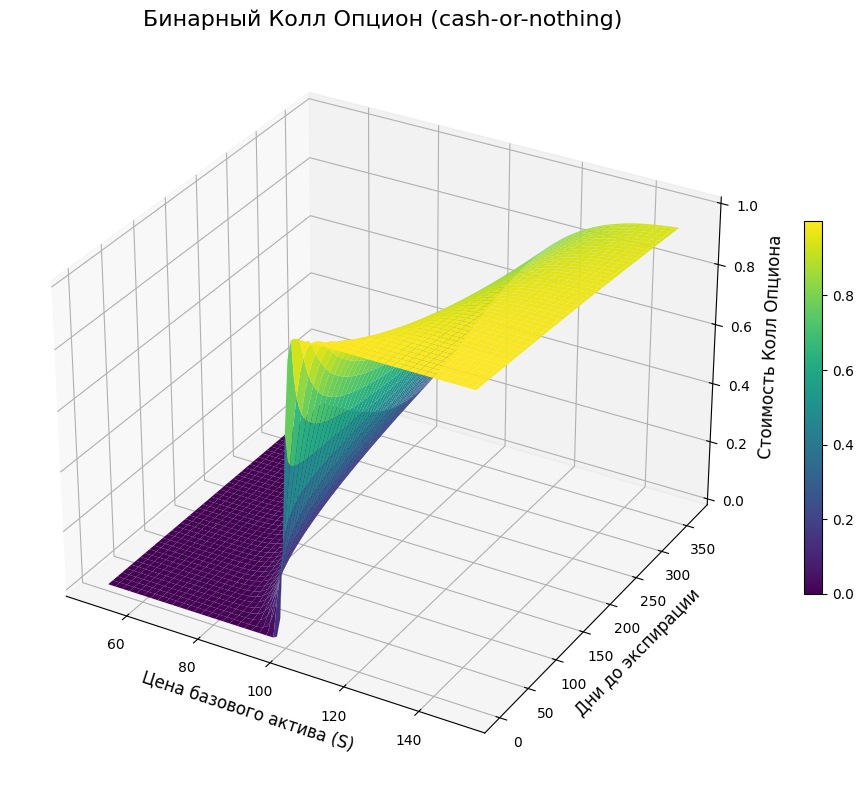

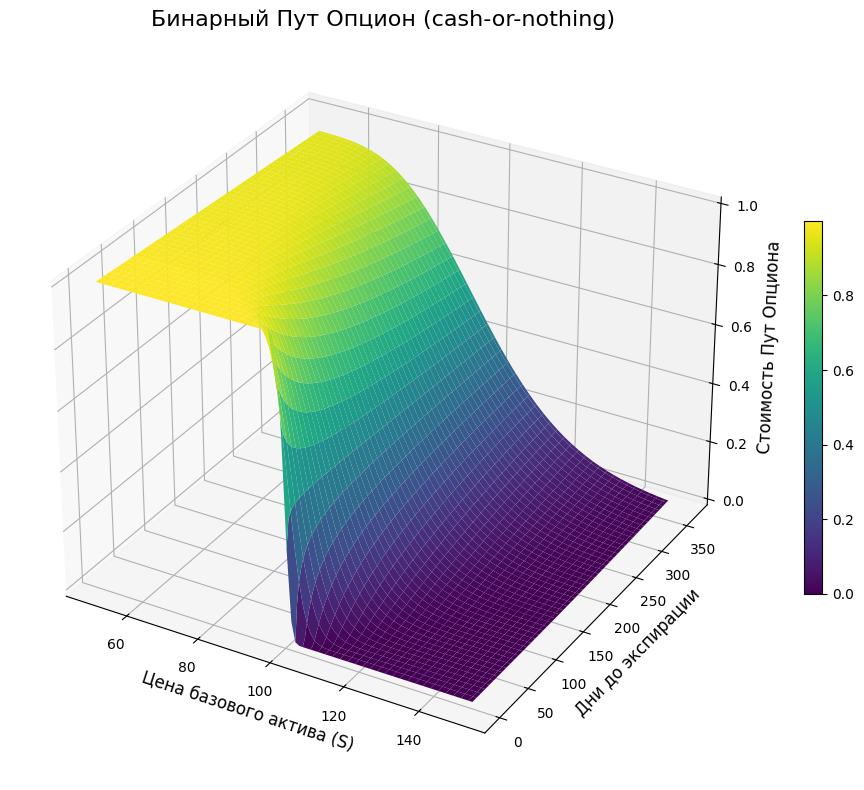

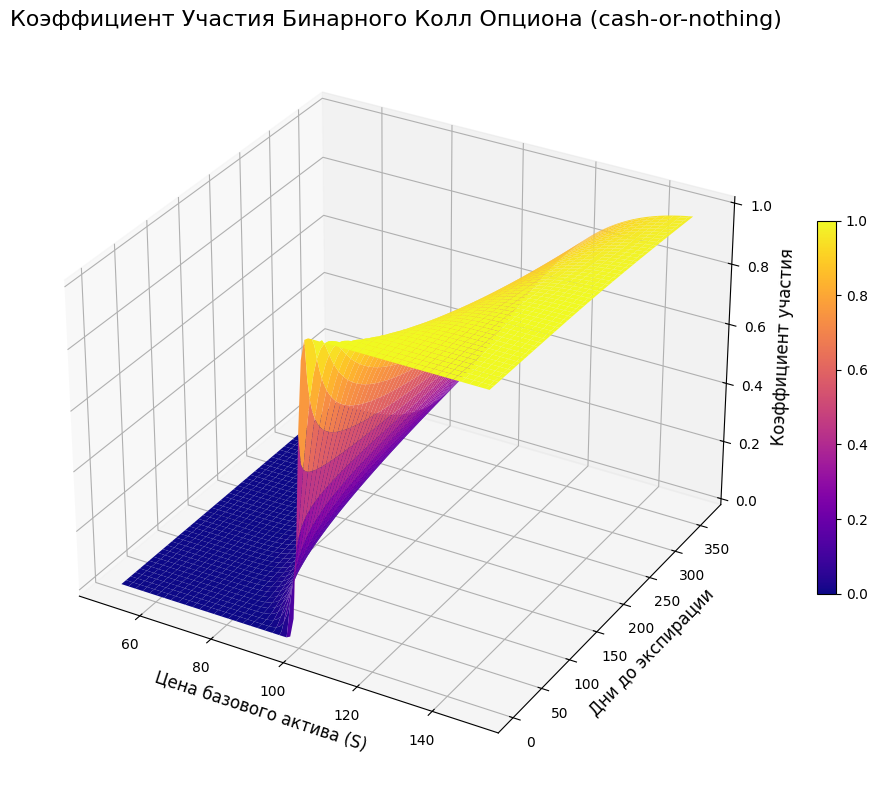

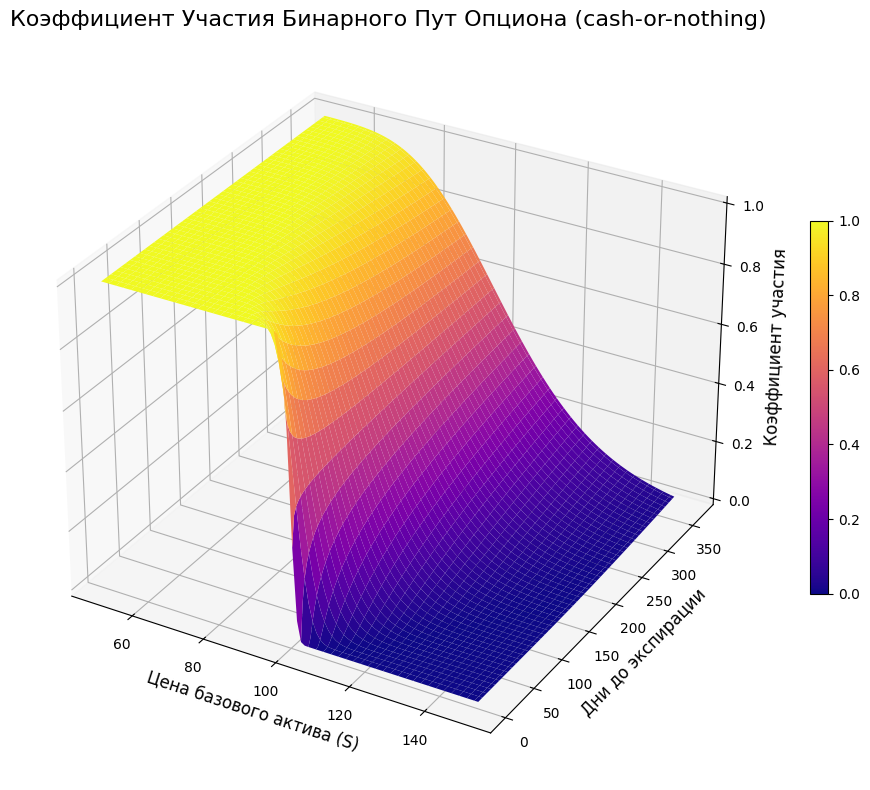

In [32]:
K = 100
r = 0.05
q = 0.02
sigma = 0.2
S_min, S_max = 50, 150
days_min, days_max = 1, 365
S = np.linspace(S_min, S_max, 100)
days = np.linspace(days_min, days_max, 100)
S_grid, days_grid = np.meshgrid(S, days)
T_grid = days_grid / 365.0
option_type = 'cash-or-nothing'


binary_call = binary_option_call(option_type, S_grid, K, T_grid, r, q, sigma)
binary_put = binary_option_put(option_type, S_grid, K, T_grid, r, q, sigma)
participation_call = participation_coefficient(option_type, 'call', S_grid, K, T_grid, sigma)
participation_put = participation_coefficient(option_type, 'put', S_grid, K, T_grid, sigma)


plot_3d(S_grid, days_grid, binary_call, f"Бинарный Колл Опцион ({option_type})", "Стоимость Колл Опциона")
plot_3d(S_grid, days_grid, binary_put, f"Бинарный Пут Опцион ({option_type})", "Стоимость Пут Опциона")
plot_3d(S_grid, days_grid, participation_call, f"Коэффициент Участия Бинарного Колл Опциона ({option_type})", "Коэффициент участия", cmap='plasma')
plot_3d(S_grid, days_grid, participation_put, f"Коэффициент Участия Бинарного Пут Опциона ({option_type})", "Коэффициент участия", cmap='plasma')

## CП с использованием гэп опционов

### Задача

Задача. Рассмотрим гэп опционы колл и пут на недивидендные акции со страйком 57 и сроком действия, истекающим 1 июля следующего года, на 1 января текущего года акции торгуются по цене 50.

Используя эти данные, вычислите цену опциона колл и пут, если безрисковая ставка равна 9%, цена страйк 50, волатильность 20%.

In [33]:
S = 50        
K1 = 57       
K2 = 50       
r = 0.09      
q = 0         
sigma = 0.2   
T = 0.5       


d1 = (np.log(S / K1) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
Nd1 = norm.cdf(d1)
Nd2 = norm.cdf(d2)
N_minus_d1 = norm.cdf(-d1)
N_minus_d2 = norm.cdf(-d2)
exp_minus_rT = np.exp(-r * T)
exp_minus_qT = np.exp(-q * T)

C = S * exp_minus_qT * Nd1 - K2 * exp_minus_rT * Nd2
P = K2 * exp_minus_rT * N_minus_d2 - S * exp_minus_qT * N_minus_d1

print(f"Цена гэп колл опциона: {C:.4f} рублей")
print(f"Цена гэп пут опциона: {P:.4f} рублей")

Цена гэп колл опциона: 2.8901 рублей
Цена гэп пут опциона: 0.6900 рублей


В рамках модели Блэка-Шоулза решите следующие задачи для бинарных опционов.

Пример. Маркет-мейкер продает европейские гэп-колл опционы сумму 1000 сроком на один год и дельта-хеджирует позицию акциями.
Опцион гэп-колл выписан на одну акцию, не приносящую дивидендов. Текущая цена акции составляет 100.

Волатильность акции составляет 100\%. Каждый колл-гэп опцион  имеет цену исполнения 130, триггер цена равна  100. Безрисковая процентная ставка равна 0\%.

В рамках модели Блэка-Шоулза определите начальное количество акций для  дельта-хеджирования.

**Указание.** Определите дельту опциона и умножьте на 1000.

In [24]:
def first_derivative (f , x , args, h = 0.0001) :
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

In [34]:
def gap_option_price_call(S, K1, K2, T, r, q, sigma):
    d1 = (np.log(S / K2) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * np.exp(-q * T) * norm.cdf(d1) - K1 * np.exp(-r * T) * norm.cdf(d2)
    return price

def gap_option_price_put(S, K1, K2, T, r, q, sigma):
    d1 = (np.log(S / K2) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K1 * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return price


def first_derivative(f, x, args, h=0.0001):
    return (f(x + h, *args) - f(x - h, *args)) / (2 * h)

S = 90
K1 = 130  
K2 = 100
r = 0.0
sigma = 1
T = 1
q = 0

c = gap_option_price_call(S, K1, K2, T, r, q, sigma)
delta = first_derivative(gap_option_price_call, S, (K1, K2, T, r, q, sigma))

(c, round(delta * 1000))

(np.float64(23.38903016242041), 543)

### Задача

Задача. В условиях примера определите начальное количество акций для дельта-хеджирования с использованием пут-гэп опционов. Выбор цены исполнения и триггер цены обосновать.

In [35]:
S = 80        
K1 = 130        
K2 = 100       
r = 0.0        
sigma = 1      
T = 1          
q = 0          


p = gap_option_price_put(S, K1, K2, T, r, q, sigma)
delta = first_derivative(gap_option_price_put, S, (K1, K2, T, r, q, sigma))
number_of_shares = delta * 1000  

print(f"Цена пут-гэп опциона: {p:.4f}")
print(f"Дельта опциона: {delta:.4f}")
print(f"Начальное количество акций для дельта-хеджирования: {round(number_of_shares)}")

Цена пут-гэп опциона: 68.2009
Дельта опциона: -0.5061
Начальное количество акций для дельта-хеджирования: -506


Пример. Безрисковая процентная ставка составляет 6%, волатильность бездивидендных акций составляет 32%. Четырехлетний опцион пут «деньги или ничего» на эту акцию с триггерной ценой 135 имеет премию 0,32494. Найдите цену 4-летнего опциона колл «актив или ничего» на эту акцию с триггерной ценой 135.

In [36]:
r = 0.06
sigma = 0.32
T = 4
K = 135
q = 0
put = 0.32494
put_type = 'cash-or-nothing'

opt_func = lambda x: binary_option_put(put_type, x, K, T, r, q, sigma) - put
S = fsolve(opt_func, K)[0]

call_type = 'asset-or-nothing'
call = binary_option_call(call_type, S, K, T, r, q, sigma)
call

np.float64(120.75083564309931)

Пример. Волатильность базового актива 25%, волатильность годового опциона колл со страйком 50 на акции составляет 120,68%. Маркет-мейкер выписывает один опцион колл и дельта хеджирует свою позицию. Стоимость акции в хеджирующем портфеле равна 34,74. Найдите цену годового опциона «деньги или ничего» колл на акцию с триггерной ценой 50.

In [37]:
r = 0.00
sigma_S = 0.25
sigma_call = 1.2068
K = 50
T = 1
K2 = 50
S_hedge = 34.74
q = 0
call_type = 'cash-or-nothing'
call = binary_option_call(call_type, S_hedge, K, T, r, q, sigma_S)
call

np.float64(0.05687902614969493)

### Задача

Задача. На акции по текущей цене 75 выплачивают дивиденды по ставке 2% (непрырывное начисление), волатильность акций 40%. Коэффициент Шарпа для акции равен 0. Шестимесячный опцион «актив или ничего» колл на акцию с триггером 80 стоит 36,65.

Рассчитайте вероятность того, что опцион колл «актив или ничего» будет исполнен.

В условиях примера проанализируйте зависимость вероятности исполнения опциона колл «актив или ничего» от коэффициента Шарпа.

Приведите иллюстративные графики.

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Данные задачи
S0 = 75  # Начальная цена акции
sigma = 0.4  # Волатильность
q = 0.02  # Ставка дивидендов
sharpe = 0.0  # Коэффициент Шарпа
r = np.abs(sharpe - q)  # Безрисковая ставка
c = 36.65  # Стоимость опциона
K = 80  # Страйк
T = 0.5  # Время до экспирации (6 месяцев)

d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# Вероятность исполнения опциона
P = norm.cdf(d2)

print(f"Вероятность исполнения опциона: {P:.4f}")

Вероятность исполнения опциона: 0.3558


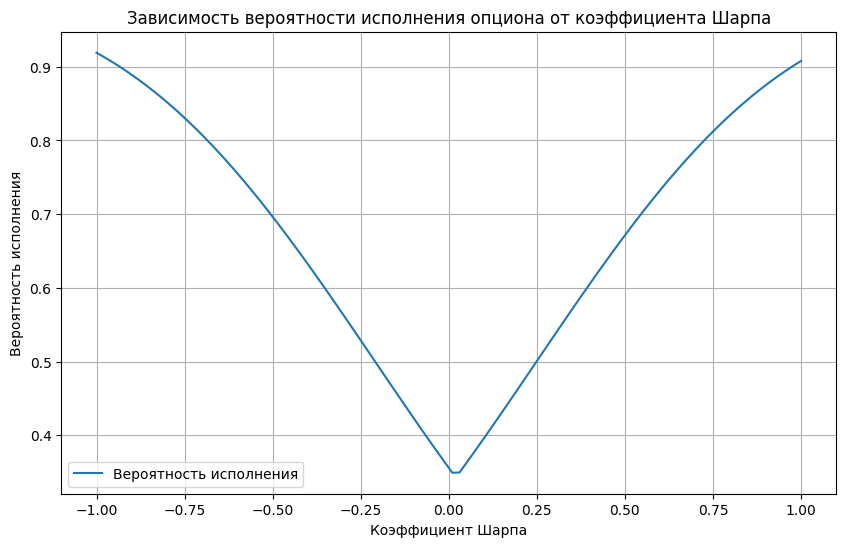

In [ ]:
# Диапазон коэффициента Шарпа
sharpe_values = np.linspace(-1, 1, 100)

# Массив вероятностей
probabilities = []

# Вычисление вероятности для каждого значения коэффициента Шарпа
for sharpe in sharpe_values:
    r = np.abs(sharpe - q)
    d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    P = norm.cdf(d2)
    probabilities.append(P)

plt.figure(figsize=(10, 6))
plt.plot(sharpe_values, probabilities, label='Вероятность исполнения')
plt.xlabel('Коэффициент Шарпа')
plt.ylabel('Вероятность исполнения')
plt.title('Зависимость вероятности исполнения опциона от коэффициента Шарпа')
plt.grid(True)
plt.legend()
plt.show()